In [48]:
from datetime import datetime

def parse_timestamp(timestamp1, timestamp2):
    fmt = '%Y-%m-%d %H:%M:%S.%f'
    tstamp1 = datetime.strptime(timestamp1, fmt)
    tstamp2 = datetime.strptime(timestamp2, fmt)

    if tstamp1 > tstamp2:
        td = tstamp1 - tstamp2
    else:
        td = tstamp2 - tstamp1
    
    return td.total_seconds()

timestamp1 = "2024-12-05 23:59:59.999"
timestamp2 = "2024-12-06 00:00:00.017"
print(f'The difference is approx. {parse_timestamp(timestamp1, timestamp2)} seconds')

The difference is approx. 0.018 seconds


In [49]:
def create_network_data(file_name):
    results_file = open(file_name)
    results_dict = {
        "timestamps": [],
        "cwnd": [],
        "ssthresh": [],
        "throughput": [],
        "mean_rtt": [],
        "rtt_var": [],
    }

    # Initialize variables
    prev_timestamp = results_file.readline()[1:-2]
    results_dict["timestamps"].append(0)
    mss = -1 # Initializing MSS
    conversion_factors_bitrate = {"Gbps": pow(10,3), "Mbps": 1}

    # Parse log file
    for line in results_file:
        line = line.strip()
        if "[" in line:
            # Fill missing throughput (delivery_rate) and ssthresh with 0
            if len(results_dict["throughput"]) < len(results_dict["timestamps"]):
                results_dict["throughput"].append(0)
            if len(results_dict["ssthresh"]) < len(results_dict["timestamps"]):
                results_dict["ssthresh"].append(0)

            curr_timestamp = line[1:-1]
            elapsed_time = parse_timestamp(prev_timestamp, curr_timestamp)
            results_dict["timestamps"].append(results_dict["timestamps"][-1] + elapsed_time)
            prev_timestamp = curr_timestamp
        elif "mss" in line:
            mss = int(line[4:])

        elif "cwnd" in line:
            cwnd_mbytes = int(line[5:]) * mss * pow(10, -6)
            results_dict["cwnd"].append(cwnd_mbytes)

        elif "ssthresh" in line:
            ssthresh_mbytes = int(line[9:]) * mss * pow(10, -6)
            results_dict["ssthresh"].append(ssthresh_mbytes)

        elif "delivery_rate" in line:
            throughput_value = float(line[14:-4])
            unit = line[-4:]
            converted_throughput = conversion_factors_bitrate[unit] * throughput_value
            results_dict["throughput"].append(converted_throughput)

        elif "rtt" in line:
            rtt_val = line[4:].split('/')
            results_dict["mean_rtt"].append(float(rtt_val[0]))
            results_dict["rtt_var"].append(float(rtt_val[1]))

    # Handle remaining missing throughput and ssthresh entries
    while len(results_dict["throughput"]) < len(results_dict["timestamps"]):
        results_dict["throughput"].append(0)
    while len(results_dict["ssthresh"]) < len(results_dict["timestamps"]):
        results_dict["ssthresh"].append(0)

    return results_dict

In [50]:
file_name1 = "cubic-20ms-delay"
results_dict1 = create_network_data(f"./cubic_results/{file_name1}.txt")

file_name2 = "cubic-20ms-delay-0.005-loss"
results_dict2 = create_network_data(f"./cubic_results/{file_name2}.txt")

file_name3 = "cubic-20ms-delay-0.01-loss"
results_dict3 = create_network_data(f"./cubic_results/{file_name3}.txt")

file_name4 = "bbr-20ms-delay"
results_dict4 = create_network_data(f"./bbr_results/{file_name4}.txt")

file_name5 = "bbr-20ms-delay-0.005-loss"
results_dict5 = create_network_data(f"./bbr_results/{file_name5}.txt")

file_name6 = "bbr-20ms-delay-0.01-loss"
results_dict6 = create_network_data(f"./bbr_results/{file_name6}.txt")

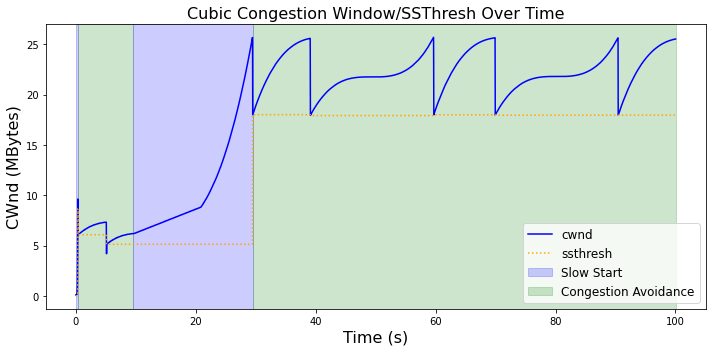

In [51]:
# Cubic Congestion Window for 20ms delay
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

# Congestion Window
axs.plot(results_dict1["timestamps"], results_dict1["cwnd"], label='cwnd', color='blue')
axs.plot(results_dict1["timestamps"], results_dict1["ssthresh"], label='ssthresh', color='orange', linestyle='dotted')
axs.set_ylabel('CWnd (MBytes)', fontsize=16)
axs.set_title('Cubic Congestion Window/SSThresh Over Time', fontsize=16)
axs.set_xlabel('Time (s)', fontsize=16)

# Slow Start vs Congestion Avoidance
plt.axvspan(0, results_dict1["timestamps"][27], color='blue', alpha=0.2, label='Slow Start')
plt.axvspan(results_dict1["timestamps"][27], results_dict1["timestamps"][650], color='green', alpha=0.2, label='Congestion Avoidance')
plt.axvspan(results_dict1["timestamps"][650], results_dict1["timestamps"][1980], color='blue', alpha=0.2)
plt.axvspan(results_dict1["timestamps"][1980], results_dict1["timestamps"][-1], color='green', alpha=0.2)

# # ssthresh
plt.tight_layout()
plt.legend(fontsize=12)
plt.savefig(f"./cubic_results/{file_name1}_cwnd.png")
plt.show()

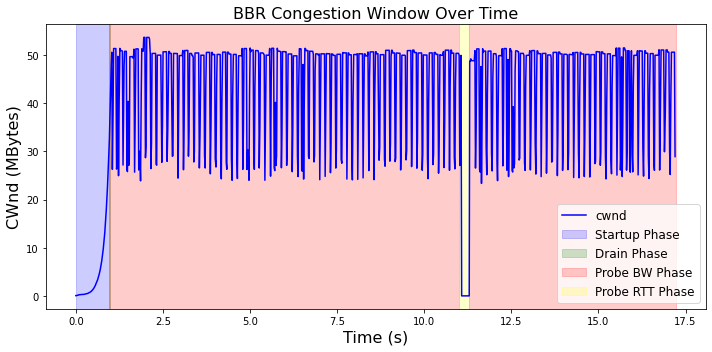

In [52]:
# BBR Congestion Window under 20ms Delay
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

# Congestion Window
axs.plot(results_dict4["timestamps"][:1000], results_dict4["cwnd"][:1000], label='cwnd', color='blue')
axs.set_ylabel('CWnd (MBytes)', fontsize=16)
axs.set_title('BBR Congestion Window Over Time', fontsize=16)
axs.set_xlabel('Time (s)', fontsize=16)

# Slow Start vs Congestion Avoidance
plt.axvspan(0, results_dict4["timestamps"][66], color='blue', alpha=0.2, label='Startup Phase')
plt.axvspan(results_dict4["timestamps"][66], results_dict4["timestamps"][67], color='green', alpha=0.2, label='Drain Phase')
plt.axvspan(results_dict4["timestamps"][67], results_dict4["timestamps"][636], color='red', alpha=0.2, label="Probe BW Phase")
plt.axvspan(results_dict4["timestamps"][636], results_dict4["timestamps"][655], color='yellow', alpha=0.2, label="Probe RTT Phase")
plt.axvspan(results_dict4["timestamps"][655], results_dict4["timestamps"][1000], color='red', alpha=0.2)

# ssthresh
plt.tight_layout()
plt.legend(fontsize=12)
plt.savefig(f"./bbr_results/{file_name4}_cwnd.png")
plt.show()


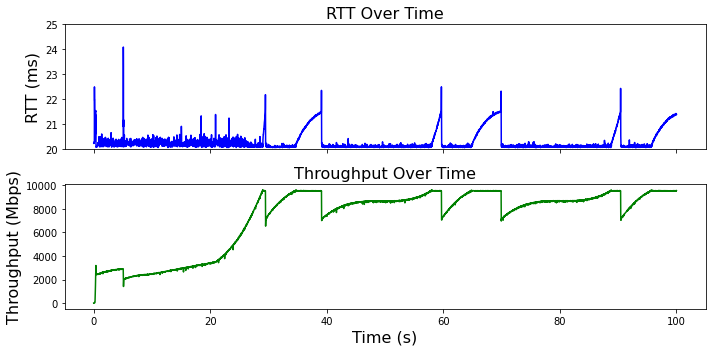

In [53]:
# Cubic Plots for Throughput and RTT under 20ms Delay
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# RTT for Cubic
axs[0].plot(results_dict1["timestamps"], results_dict1["mean_rtt"], color='blue')
axs[0].set_ylabel('RTT (ms)', fontsize=16)
axs[0].set_title('RTT Over Time', fontsize=16)
axs[0].set_ylim(20, 25)

# # Throughput
axs[1].plot(results_dict1["timestamps"], results_dict1["throughput"], color='green')
axs[1].set_ylabel('Throughput (Mbps)', fontsize=16)
axs[1].set_title('Throughput Over Time', fontsize=16)
axs[1].set_xlabel('Time (s)', fontsize=16)

plt.tight_layout()
plt.savefig(f"./cubic_results/cubic_metrics.png")
plt.show()


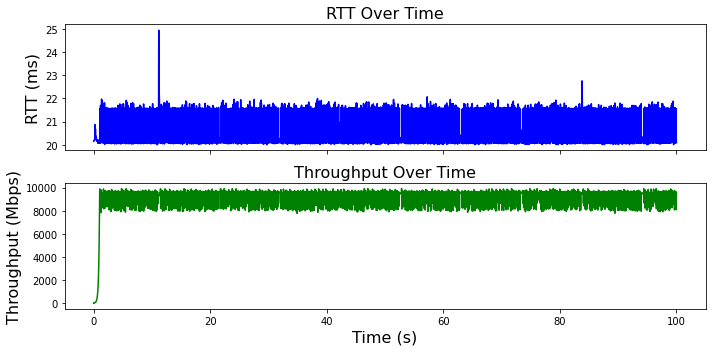

In [54]:
# BBR Metrics for Throughput and RTT under 20ms Delay
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# RTT
axs[0].plot(results_dict4["timestamps"], results_dict4["mean_rtt"], color='blue')
axs[0].set_ylabel('RTT (ms)', fontsize=16)
axs[0].set_title('RTT Over Time', fontsize=16)

# Throughput
axs[1].plot(results_dict4["timestamps"], results_dict4["throughput"], color='green')
axs[1].set_ylabel('Throughput (Mbps)', fontsize=16)
axs[1].set_title('Throughput Over Time', fontsize=16)
axs[1].set_xlabel('Time (s)', fontsize=16)

plt.tight_layout()
plt.savefig(f"./bbr_results/bbr_metrics.png")
plt.show()


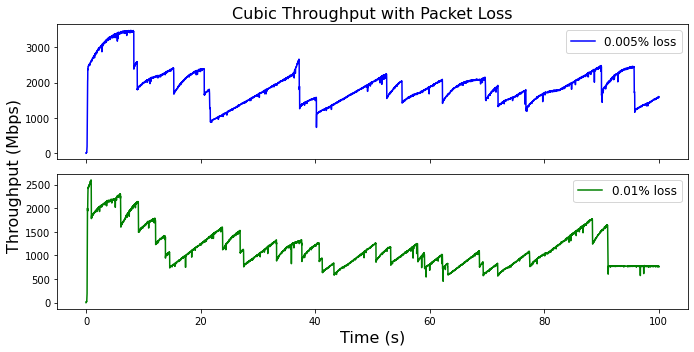

In [55]:
# Cubic Plot for Throughput with 0.005% and 0.01% Loss under 20ms Delay
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# Throughput for Cubic 0.005
axs[0].plot(results_dict2["timestamps"], results_dict2["throughput"], label="0.005% loss", color='blue')
axs[0].legend(fontsize=12)
axs[0].set_title("Cubic Throughput with Packet Loss", fontsize=16)

# Throughput for Cubic 0.01
axs[1].plot(results_dict3["timestamps"], results_dict3["throughput"], label="0.01% loss", color='green')
axs[1].set_xlabel('Time (s)', fontsize=16)
axs[1].legend(fontsize=12)

fig.text(0.04, 0.5, 'Throughput (Mbps)', va='center', rotation='vertical', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0.05, 0, 1, 1])  # Leave space for the shared y-axis label
plt.savefig(f"./cubic_results/cubic_packet_loss_throughput.png")
plt.show()


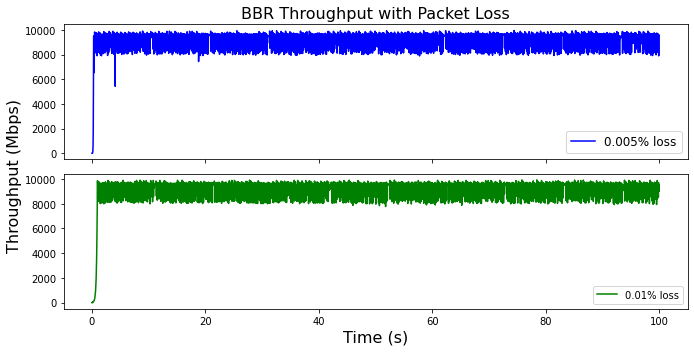

In [56]:
# BBR Plot for Throughput with 0.005% and 0.01% Loss under 20ms Delay
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# Throughput for BBR 0.005
axs[0].plot(results_dict5["timestamps"], results_dict5["throughput"], label="0.005% loss", color='blue')
axs[0].legend(fontsize=12)
axs[0].set_title("BBR Throughput with Packet Loss", fontsize=16)

# Throughput for BBR 0.01
axs[1].plot(results_dict6["timestamps"], results_dict6["throughput"], label="0.01% loss", color='green')
axs[1].set_xlabel('Time (s)', fontsize=16)
axs[1].legend(fontsize=12)
fig.text(0.04, 0.5, 'Throughput (Mbps)', va='center', rotation='vertical', fontsize=16)

# Adjust layout
plt.legend()
plt.tight_layout(rect=[0.05, 0, 1, 1])  # Leave space for the shared y-axis label
plt.savefig(f"./bbr_results/bbr_packet_loss_throughput.png")
plt.show()
